<a href="https://colab.research.google.com/github/mc-friday/hanghaeAI/blob/main/%5B4%EC%A3%BC%EC%B0%A8%5D%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [4주차] 기본과제: HuggingFace로 두 문장의 논리적 모순 분류하기

In [1]:
!pip install transformers datasets evaluate accelerate scikit-learn sacrebleu sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 r

In [2]:
import time
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import transformers
transformers.logging.set_verbosity_error()

## 1. [MY_CODE] 데이터셋 로드

- **과제 요구사항:**
    - load_dataset("nyu-mll/glue", "mnli") 로 dataset을 불러옵니다
    - 학습 때는 train split만 활용하셔야 합니다.
    - 나머지 split은 사용불가입니다.
    - Validation data가 필요한 경우, train split에서 가져오셔야 합니다
    - validation_matched에 대한 성능을 출력하고, 50%를 넘기셔야 합니다.

In [3]:
print("[LOG] Loading dataset...")
dataset = load_dataset("nyu-mll/glue", "mnli") # [과제적용]
train_split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_data = train_split["train"]  # [과제적용] 학습용 데이터
validation_data = train_split["test"] # [과제적용] Validation 데이터 (train split에서 분리)
validation_matched_data = dataset["validation_matched"]  # [과제적용] validation_matched에 대한 성능을 출력에 사용

[LOG] Loading dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

## 2. [MY_CODE] DistilBERT 토크나이저 로드 및 데이터 전처리

- **입력:** premise에 해당하는 문장과 hypothesis에 해당하는 문장 두 개가 입력으로 들어옵니다.


In [4]:
print("[LOG] Tokenizing dataset...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):

    # premise와 hypothesis를 입력으로 처리
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        max_length=128
    )

train_data = train_data.map(preprocess_function, batched=True)  # 학습 데이터 전처리
validation_data = validation_data.map(preprocess_function, batched=True)  # Validation 데이터 전처리

# 데이터셋에서 메모리 낭비를 줄이기 위해 불필요한 열 제거
train_data = train_data.remove_columns(["premise", "hypothesis"])
validation_data = validation_data.remove_columns(["premise", "hypothesis"])

[LOG] Tokenizing dataset...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/314161 [00:00<?, ? examples/s]

Map:   0%|          | 0/78541 [00:00<?, ? examples/s]

## 3. [MY_CODE] 모델 정의

- **출력:** 분류 문제로, 두 문장이 들어왔을 때 다음 세 가지를 예측하시면 됩니다.
    - **Entailment:** 두 문장에 논리적 모순이 없습니다.
    - **Neutral:** 두 문장은 논리적으로 관련이 없습니다.
    - **Contradiction:** 두 문장 사이에 논리적 모순이 존재합니다.

In [5]:
print("[LOG] Loading model...")
# DistilBERT 모델을 로드하며, num_labels=3으로 세 가지 클래스를 예측합니다 (Entailment, Neutral, Contradiction)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model

[LOG] Loading model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## 4. [MY_CODE] 평가 지표 정의

In [6]:
def compute_metrics(pred):
    # 평가 지표는 정확도, F1 점수, 정밀도, 재현율로 구성됩니다.
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

## 5. [MY_CODE] 하이퍼파라미터 설정

In [7]:
print("[LOG] Setting up training arguments...")
training_args = TrainingArguments(
    output_dir="./mnli_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    seed=42,
)

[LOG] Setting up training arguments...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 6. [MY_CODE] Trainer 설정

In [8]:
print("[LOG] Setting up Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,  # [과제적용] train split만 학습에 사용
    eval_dataset=validation_data,  # [과제적용] Validation data는 train split에서 분리해 사용
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

[LOG] Setting up Trainer...


<ipython-input-8-0accdb64ca04>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## 7. [MY_CODE] 시각화 함수 정의

In [9]:
def plot_metric(metric_values, metric_name, target=None):
    plt.figure(figsize=(14, 10))
    plt.plot(range(1, len(metric_values) + 1), metric_values, marker="o", label=metric_name)
    if target:
        plt.axhline(y=target, color="r", linestyle="--", label=f"Target ({target})")
    plt.title(f"{metric_name} per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()
    print("\n\n")


## 8. 학습

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


[LOG] Starting training...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'loss': 0.6285, 'grad_norm': 9.731270790100098, 'learning_rate': 4.5e-05, 'epoch': 1.0}
{'eval_loss': 0.5396751165390015, 'eval_accuracy': 0.7847748309799977, 'eval_f1': 0.7847774547766283, 'eval_precision': 0.7848538786234238, 'eval_recall': 0.7847748309799977, 'eval_runtime': 200.0053, 'eval_samples_per_second': 392.695, 'eval_steps_per_second': 12.275, 'epoch': 1.0}
{'loss': 0.4628, 'grad_norm': 36.24563217163086, 'learning_rate': 4e-05, 'epoch': 2.0}
{'eval_loss': 0.5521562695503235, 'eval_accuracy': 0.7926433327816045, 'eval_f1': 0.7927057316607108, 'eval_precision': 0.7943232126711771, 'eval_recall': 0.7926433327816045, 'eval_runtime': 200.5209, 'eval_samples_per_second': 391.685, 'eval_steps_per_second': 12.243, 'epoch': 2.0}
{'loss': 0.3485, 'grad_norm': 0.10074633359909058, 'learning_rate': 3.5e-05, 'epoch': 3.0}
{'eval_loss': 0.5699028372764587, 'eval_accuracy': 0.7957245260437223, 'eval_f1': 0.7961564126757497, 'eval_precision': 0.7970520453518519, 'eval_recall': 0.79572452

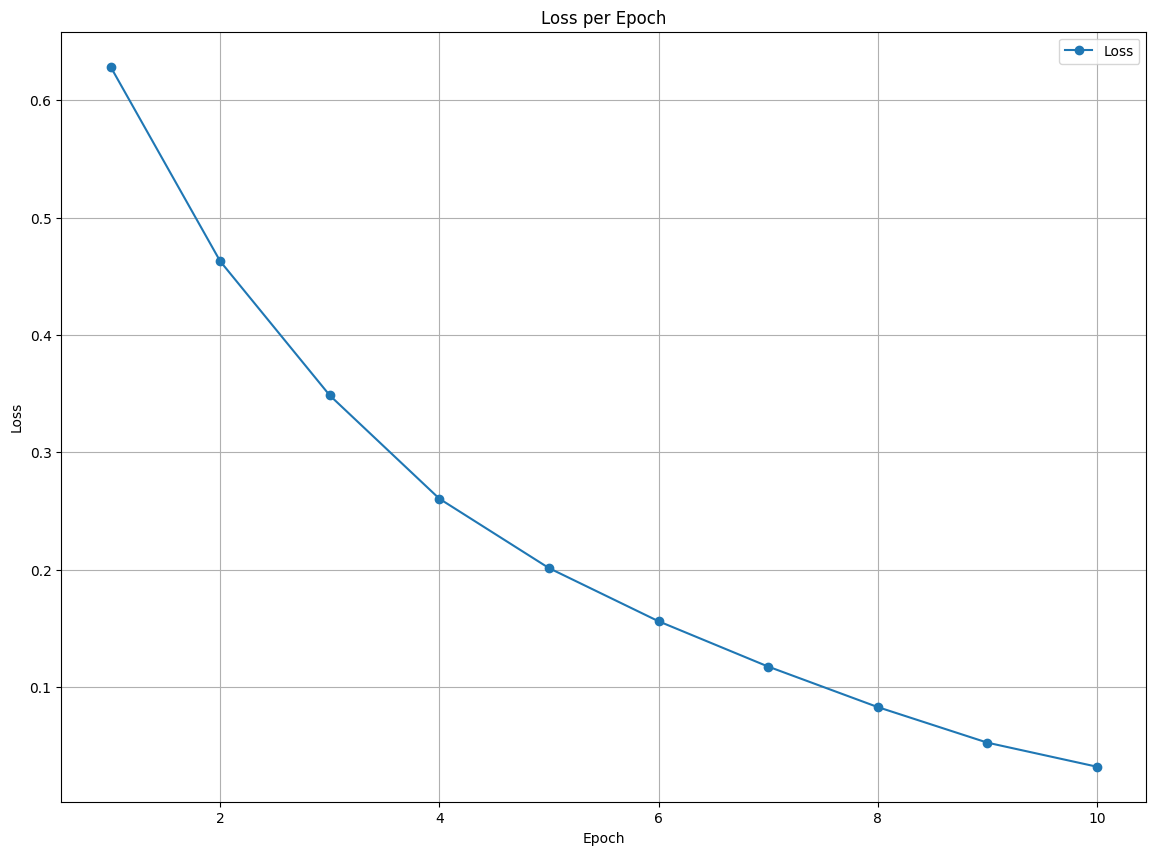

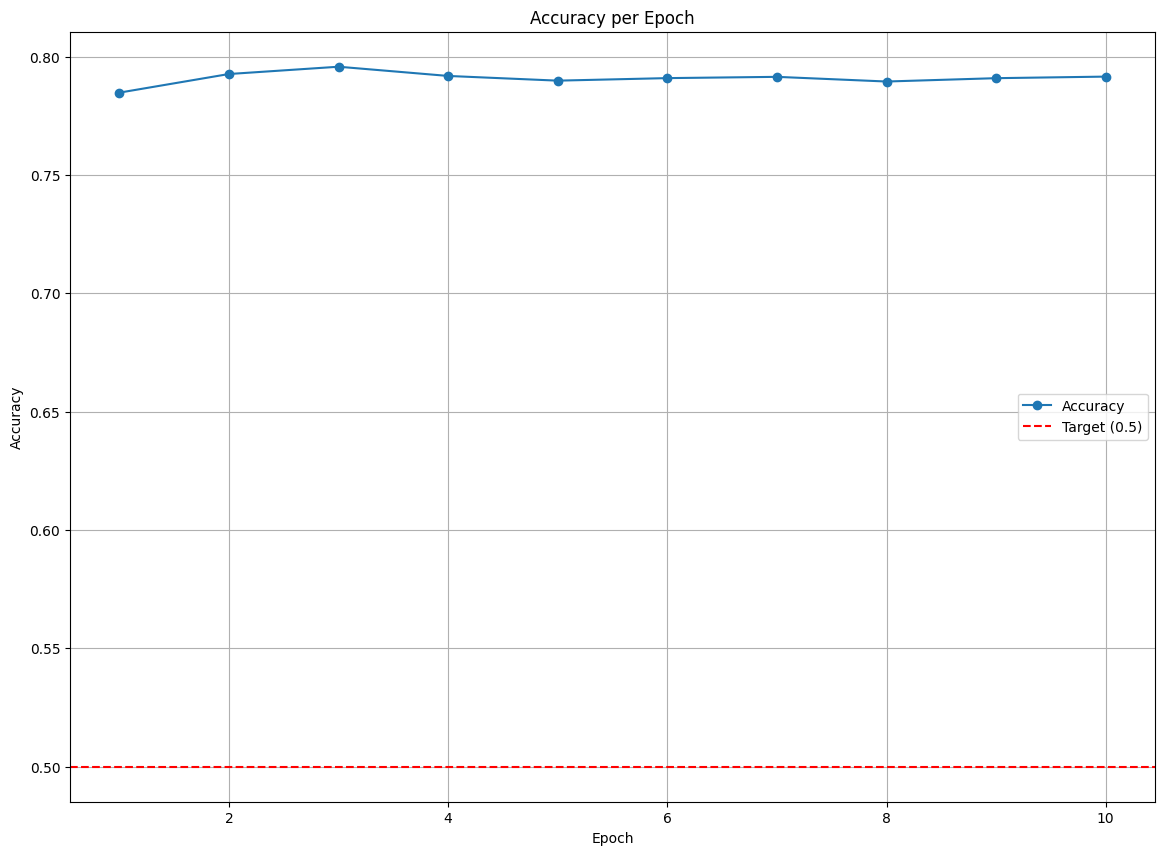

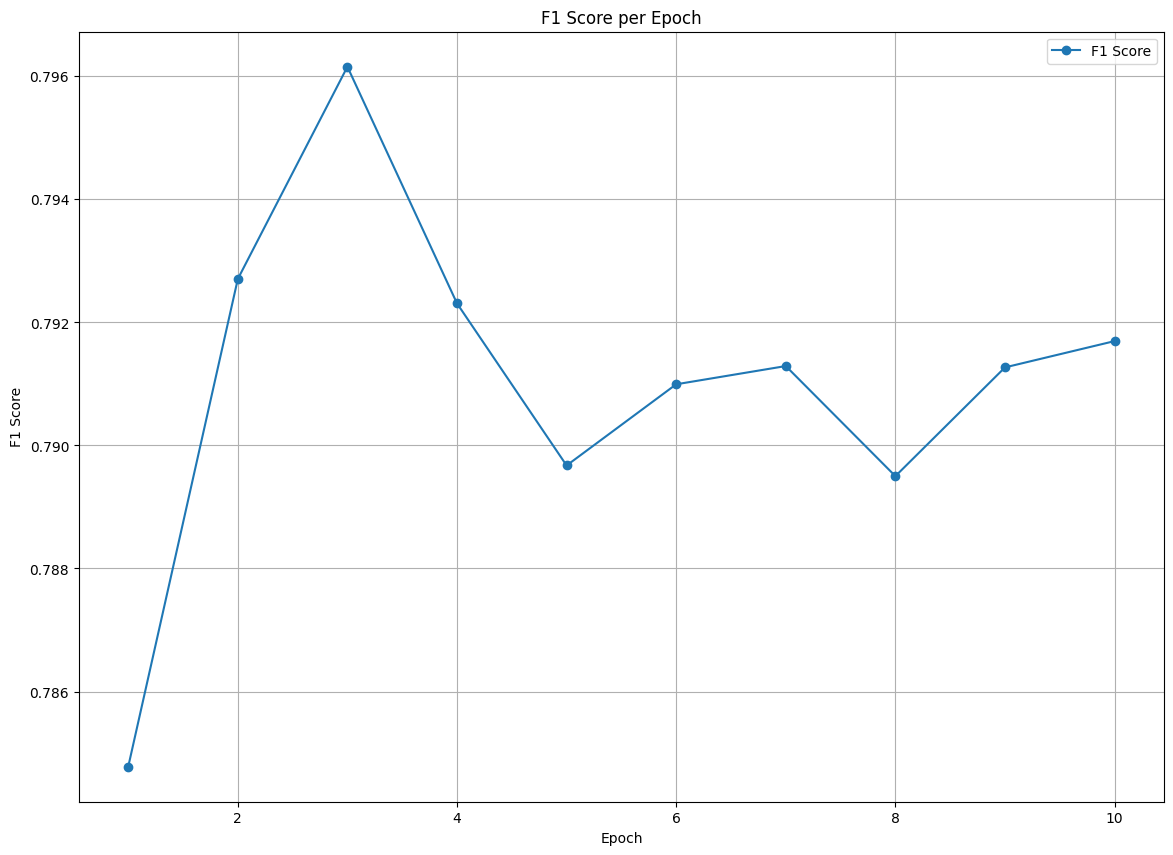

In [10]:
print("[LOG] Starting training...")
trainer.train()

# 학습 과정 시각화
history = trainer.state.log_history
losses = [log["loss"] for log in history if "loss" in log]
eval_accuracies = [log["eval_accuracy"] for log in history if "eval_accuracy" in log]
eval_f1_scores = [log["eval_f1"] for log in history if "eval_f1" in log]

# 시각화 실행
plot_metric(losses, "Loss")
plot_metric(eval_accuracies, "Accuracy", target=0.5)
plot_metric(eval_f1_scores, "F1 Score")

## 9. [MY_CODE] Validation Matched 데이터 평가

- **validation_matched에 대한 성능을 출력하고, 50%를 넘겨야함**

In [13]:
print("[LOG] Evaluating validation_matched dataset...")
results = trainer.evaluate(validation_data)  # [과제적용] Validation Matched 데이터 평가
validation_accuracy = results['eval_accuracy']  # Validation Matched 정확도 저장
print(f"[LOG] Validation Matched 정확도 : {validation_accuracy:.2f}") # [과제적용] Validation Matched 50%이상

[LOG] Evaluating validation_matched dataset...
{'eval_loss': 0.5396751165390015, 'eval_accuracy': 0.7847748309799977, 'eval_f1': 0.7847774547766283, 'eval_precision': 0.7848538786234238, 'eval_recall': 0.7847748309799977, 'eval_runtime': 200.7628, 'eval_samples_per_second': 391.213, 'eval_steps_per_second': 12.228, 'epoch': 10.0}
[LOG] Validation Matched 정확도 : 0.78


## 10. [MY_CODE] 다양한 평가 그래프 함수

In [14]:
def plot_accuracy_per_epoch(history):
    """
    Epoch별 정확도를 시각화
    """
    accuracies = [log["eval_accuracy"] for log in history if "eval_accuracy" in log]
    epochs = range(1, len(accuracies) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, accuracies, marker="o", label="Accuracy")
    plt.axhline(y=0.5, color="red", linestyle="--", label="Target (50%)")  # 50% 기준선
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Matched Accuracy per Epoch")
    plt.legend()
    plt.grid()
    plt.show()
    print("\n\n")

def plot_loss_per_epoch(history):
    """
    Epoch별 손실(Loss)을 시각화
    """
    losses = [log["loss"] for log in history if "loss" in log]
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, losses, marker="o", color="orange", label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Matched Loss per Epoch")
    plt.legend()
    plt.grid()
    plt.show()
    print("\n\n")

def plot_precision_recall_per_epoch(history):
    """
    Epoch별 Precision과 Recall을 비교하여 시각화
    """
    precisions = [log["eval_precision"] for log in history if "eval_precision" in log]
    recalls = [log["eval_recall"] for log in history if "eval_recall" in log]
    epochs = range(1, len(precisions) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, precisions, marker="o", color="blue", label="Precision")
    plt.plot(epochs, recalls, marker="o", color="purple", label="Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Matched Precision vs Recall per Epoch")
    plt.legend()
    plt.grid()
    plt.show()
    print("\n\n")

def plot_accuracy_f1_comparison(history):
    """
    Epoch별 Accuracy와 F1 Score를 비교하여 시각화합니다.
    """
    accuracies = [log["eval_accuracy"] for log in history if "eval_accuracy" in log]
    f1_scores = [log["eval_f1"] for log in history if "eval_f1" in log]
    epochs = range(1, len(accuracies) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, accuracies, marker="o", color="blue", label="Accuracy")
    plt.plot(epochs, f1_scores, marker="o", color="green", label="F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Matched Accuracy vs F1 Score per Epoch")
    plt.legend()
    plt.grid()
    plt.show()
    print("\n\n")

## 11. [MY_CODE] 그래프 출력

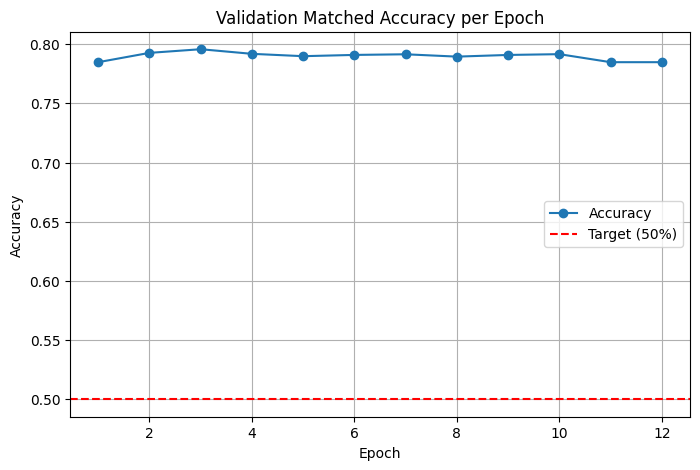

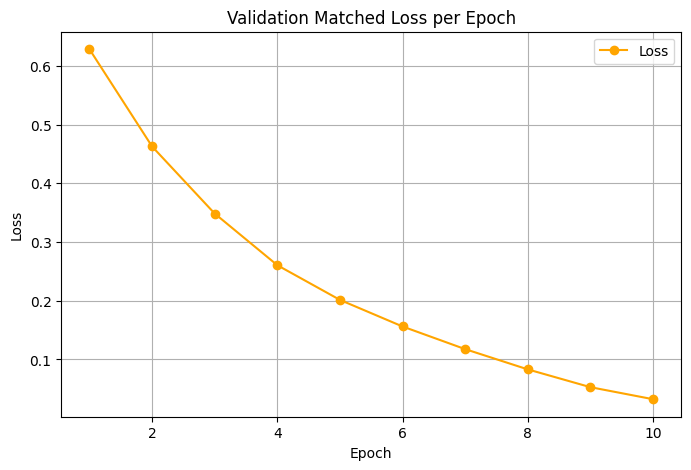

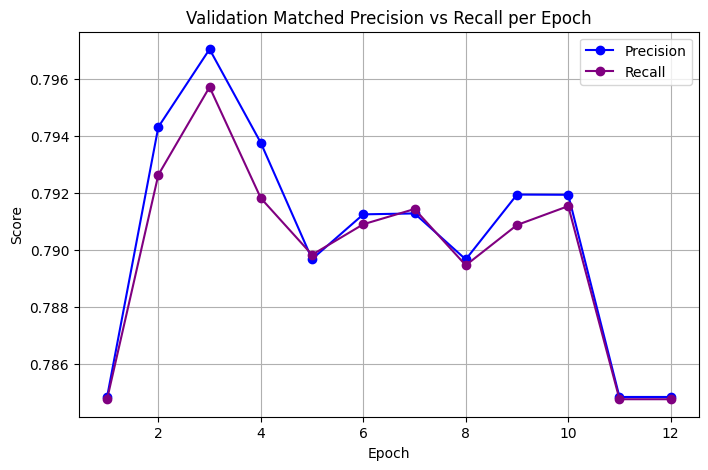

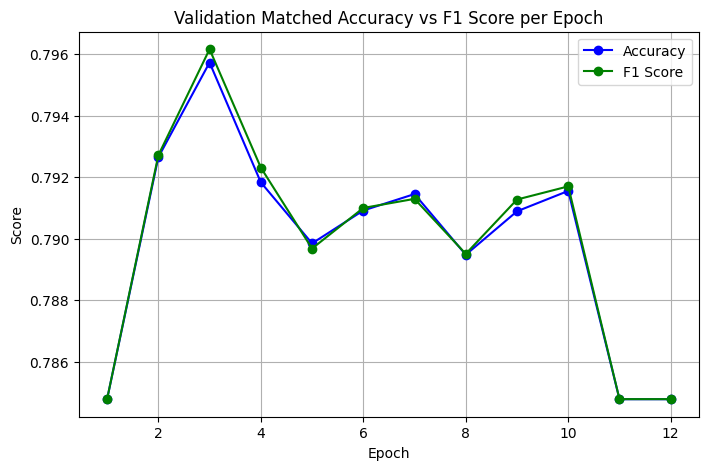

In [15]:
# 학습 로그 가져오기
history = trainer.state.log_history

# 1. Epoch당 정확도 시각화
plot_accuracy_per_epoch(history)

# 2. Epoch당 Loss 시각화
plot_loss_per_epoch(history)

# 3. Precision과 Recall 비교 시각화
plot_precision_recall_per_epoch(history)

# 4. 정확도와 F1 Score 비교 시각화
plot_accuracy_f1_comparison(history)